# Implementar o Conditional GAN

- Usar Conditional GAN: [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) com o dataset criado a partir de um grafo causal implícito

---
### Funções de auxílio

In [1]:
def plot_losses(losses_his):
    plt.figure(figsize=(20,10))
    plt.subplot(421)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador 1')
    plt.subplot(422)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador 1')
    plt.subplot(423)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D1 real')
    plt.subplot(424)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D1 fake')
    plt.subplot(425)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador 2')
    plt.subplot(426)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador 2')
    plt.subplot(427)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D2 real')
    plt.subplot(428)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D2 fake')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()

def gan_summary(intervention=False):
    oh = np.eye(2)
    batch = X_tc.shape[0]
    if intervention:
        l_s = np.random.choice([0,1],p=[0,1],size=(batch))
    else:
        l_s = np.random.choice([0,1],p=[1-rho,rho],size=(batch))
    l_s_ = torch.Tensor(oh[l_s]).type(torch.FloatTensor).cuda()
    l_s = torch.Tensor(l_s).type(torch.FloatTensor).reshape(batch,1).cuda()

    z1 = Variable(torch.randn(batch, Z1_dim)).cuda()
    z2 = Variable(torch.randn(batch, Z2_dim)).cuda()

    g1 = G1(z1)
    g2 = G2(z2,g1,l_s_)
    g2 = torch.Tensor(scaler.inverse_transform(g2.cpu().data.numpy())).type(torch.FloatTensor).cuda()
    x_gen = torch.cat((g2[:,0:5],l_s,g2[:,5:]),dim=1)

    df_g = pd.DataFrame(data=x_gen.cpu().data.numpy(),columns=df_num.columns)

    df_g['Click_probability'] = np.round(df_g['Click_probability'].values,2)
    df_g['Image_quality'] = np.round(df_g['Image_quality'].values,0)
    df_g['Number_of_images'] = np.round(df_g['Number_of_images'].values,0)
    df_g['Product_price'] = np.round(df_g['Product_price'].values,2)

    #dataset fake
    print("Fake")
    print(df_g.describe().loc[['mean','std','25%','50%','75%']])

    #dataset real
    print("Real")
    print(df_num.describe().loc[['mean','std','25%','50%','75%']])

    for col in ['Image_quality','Number_of_images','Seller_latitude','Seller_longitude','Product_price','Click_probability']:
        plt.figure(figsize=(15,3))
        sns.distplot(df_num[col],label='Real',bins=40)
        sns.distplot(df_g[col],label='Fake',bins=40)
        plt.legend(loc=0)
        plt.grid(True)
        plt.show()

---

## ConditionalGAN

In [2]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
from torch.distributions import Uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import pandas as pd
import numpy as np

In [3]:
df_num = pd.read_csv('data/shap_dataset_50k_modified.csv')

In [5]:
# probabilidade de ocorrer Free_shipment=1 no dataset
rho = df_num[df_num["Free_shipment"]==1].shape[0]/df_num.shape[0]
rho

0.26368

In [6]:
X_data = df_num.drop("Free_shipment",axis=1).copy().values
scaler.fit(X_data)
X_data = scaler.transform(X_data)
y_data = pd.get_dummies(df_num["Free_shipment"]).values.reshape(X_data.shape[0],2)
X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
y_tc = torch.Tensor(y_data).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([50000, 6]) torch.FloatTensor torch.Size([50000, 2]) torch.FloatTensor


In [7]:
Z1_dim,Z2_dim,h_dim,X_dim,y_dim = [100,100,100,X_tc.shape[1],y_tc.shape[1]]

# Arquitetura do Gerador
class GNet1(torch.nn.Module):
    def __init__(self):
        super(GNet1,self).__init__()
        self.hidden = torch.nn.Linear(Z1_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 4)
    
    def forward(self,z):
        h = F.relu(self.hidden(z))
        h = nn.Dropout(p=0.25)(h)
        X = torch.sigmoid(self.out(h))
        return X
    
class GNet2(torch.nn.Module):
    def __init__(self):
        super(GNet2,self).__init__()
        self.hidden = torch.nn.Linear(Z2_dim+6, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,x,l):
        h = F.relu(self.hidden(torch.cat((z,x,l),dim=1)))
        h = nn.Dropout(p=0.25)(h)
        X = torch.sigmoid(self.out(h))
        return X

# Arquitetura do Discriminador
class DNet2(torch.nn.Module):
    def __init__(self):
        super(DNet2,self).__init__()
        self.hidden = torch.nn.Linear(X_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X,l):
        h = F.relu(self.hidden(torch.cat((X,l),dim=1)))
        h = nn.Dropout(p=0.25)(h)
        y = torch.sigmoid(self.out(h))
        return y

class DNet1(torch.nn.Module):
    def __init__(self):
        super(DNet1,self).__init__()
        self.hidden = torch.nn.Linear(4, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X):
        h = F.relu(self.hidden(X))
        h = nn.Dropout(p=0.25)(h)
        y = torch.sigmoid(self.out(h))
        return y

In [8]:
# Instanciamos as redes
G1 = GNet1().cuda()
G2 = GNet2().cuda()
D1 = DNet1().cuda()
D2 = DNet2().cuda()
# Definimos os otimizadores
lrg,lrd = [1e-4,1e-4]
G1_optim = optim.Adam(G1.parameters(),lr=lrg,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrg*0.,amsgrad=False)
G2_optim = optim.Adam(G2.parameters(),lr=lrg,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrg*0.,amsgrad=False)
D1_optim = optim.Adam(D1.parameters(),lr=lrd,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrd*0.,amsgrad=False)
D2_optim = optim.Adam(D2.parameters(),lr=lrd,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrd*0.,amsgrad=False)

def reset_grad():
    G1_optim.zero_grad()
    G2_optim.zero_grad()
    D1_optim.zero_grad()
    D2_optim.zero_grad()
    
batch = X_tc.shape[0]
ones  = Variable(torch.ones(batch, 1)).cuda()
zeros = Variable(torch.zeros(batch, 1)).cuda()
D1_loss_real_func = nn.BCELoss()  
D1_loss_fake_func = nn.BCELoss()
D2_loss_real_func = nn.BCELoss()  
D2_loss_fake_func = nn.BCELoss()
G1_loss_func = nn.BCELoss()
G2_loss_func = nn.BCELoss()

def nets_test(n_sample,G1,G2,D,D2):
    z1 = Variable(torch.randn(n_sample, Z1_dim)).cuda()
    z2 = Variable(torch.randn(n_sample, Z2_dim)).cuda()
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    x1 = torch.Tensor(X_tc[:n_sample,[0,1,4,5]]).cuda()
    l = torch.Tensor(y_tc[:n_sample]).cuda()
    g1 = G1(z1)
    g2 = G2(z2,g1,l)
    D1_real = D1(x1)
    D1_fake = D1(g1)
    D2_real = D2(x,l)
    D2_fake = D2(g2,l)
    print('Average D1_real  {:.6f}| Std D1_real  {:.6f}'.format(D1_real.mean(),D1_real.std()))
    print('Average D1_fake  {:.6f}| Std D1_fake  {:.6f}'.format(D1_fake.mean(),D1_fake.std()))
    print('Average D2_real  {:.6f}| Std D2_real  {:.6f}'.format(D2_real.mean(),D2_real.std()))
    print('Average D2_fake  {:.6f}| Std D2_fake  {:.6f}'.format(D2_fake.mean(),D2_fake.std()))
    
G1_his,D1_his,D1_real_his,D1_fake_his,G2_his,D2_his,D2_real_his,D2_fake_his = [[],[],[],[],[],[],[],[]]
losses_his = [G1_his,D1_his,D1_real_his,D1_fake_his,G2_his,D2_his,D2_real_his,D2_fake_his] 

In [8]:
#load saved networks
# G.load_state_dict(torch.load('models/g_cond_gan_shap_2.pt'))
# D.load_state_dict(torch.load('models/d_cond_gan_shap_2.pt'))

In [17]:
%%time
epochs = 1000

for epoch in range(epochs):
    # Amostragem de dados
    z1 = Variable(torch.randn(batch, Z1_dim)).cuda()
    z2 = Variable(torch.randn(batch, Z2_dim)).cuda()
    X = X_tc.cuda()
    X1 = X_tc[:,[0,1,3,4]].cuda()
    l = y_tc.cuda()
    # Discriminador1 
    G1_sample = G1(z1)
    D1_real = D1(X1)
    D1_fake = D1(G1_sample)
    D1_loss_real = D1_loss_real_func(D1_real, ones)
    D1_loss_fake = D1_loss_fake_func(D1_fake, zeros)
    D1_loss = D1_loss_real + D1_loss_fake
    D1_loss.backward()
    D1_optim.step() 
    # Discriminador 2
    G1_sample = G1(z1)
    G2_sample = G2(z2,G1_sample,l)
    D2_real = D2(X,l)
    D2_fake = D2(G2_sample,l)
    D2_loss_real = D2_loss_real_func(D2_real, ones)
    D2_loss_fake = D2_loss_fake_func(D2_fake, zeros)
    D2_loss = D2_loss_real + D2_loss_fake
    D2_loss.backward()
    D2_optim.step()
    reset_grad()
    # Generador
    z1 = Variable(torch.randn(batch, Z1_dim)).cuda()
    z2 = Variable(torch.randn(batch, Z2_dim)).cuda()
    G1_sample = G1(z1)
    G2_sample = G2(z2,G1_sample,l)
    D1_fake = D1(G1_sample)
    D2_fake = D2(G2_sample,l)
    G1_loss = G1_loss_func(D1_fake, ones)
    G2_loss = G2_loss_func(D2_fake, ones)
    G1_loss.backward(retain_graph=True)
    G2_loss.backward()
    G1_optim.step()
    G2_optim.step()
    reset_grad()
    # Recolher dados das funções de perda
    G1_his.append(G1_loss.data)
    G2_his.append(G2_loss.data)
    D1_his.append(D1_loss.data)
    D1_fake_his.append(D1_loss_fake.data)
    D1_real_his.append(D1_loss_real.data)
    D2_his.append(D2_loss.data)
    D2_fake_his.append(D2_loss_fake.data)
    D2_real_his.append(D2_loss_real.data)
    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/5) == 0 and epoch > 0:
        print('Epoch-{}'.format(epoch))
        nets_test(30000,G1,G2,D1,D2)

Epoch-200
Average D1_real  0.505330| Std D1_real  0.010106
Average D1_fake  0.501804| Std D1_fake  0.014441
Average D2_real  0.497462| Std D2_real  0.011401
Average D2_fake  0.500256| Std D2_fake  0.010356
Epoch-400
Average D1_real  0.493531| Std D1_real  0.009973
Average D1_fake  0.494211| Std D1_fake  0.013523
Average D2_real  0.502722| Std D2_real  0.013913
Average D2_fake  0.504712| Std D2_fake  0.011724
Epoch-600
Average D1_real  0.499736| Std D1_real  0.010560
Average D1_fake  0.498985| Std D1_fake  0.012157
Average D2_real  0.496331| Std D2_real  0.017513
Average D2_fake  0.495572| Std D2_fake  0.016292
Epoch-800
Average D1_real  0.504736| Std D1_real  0.012502
Average D1_fake  0.507999| Std D1_fake  0.014057
Average D2_real  0.496243| Std D2_real  0.012355
Average D2_fake  0.493215| Std D2_fake  0.012040
CPU times: user 4min 37s, sys: 4.25 s, total: 4min 41s
Wall time: 2min 21s


In [10]:
nets_test(50000,G1,G2,D1,D2)

Average D1_real  0.491385| Std D1_real  0.009958
Average D1_fake  0.498369| Std D1_fake  0.012079
Average D2_real  0.499668| Std D2_real  0.015981
Average D2_fake  0.496049| Std D2_fake  0.015485


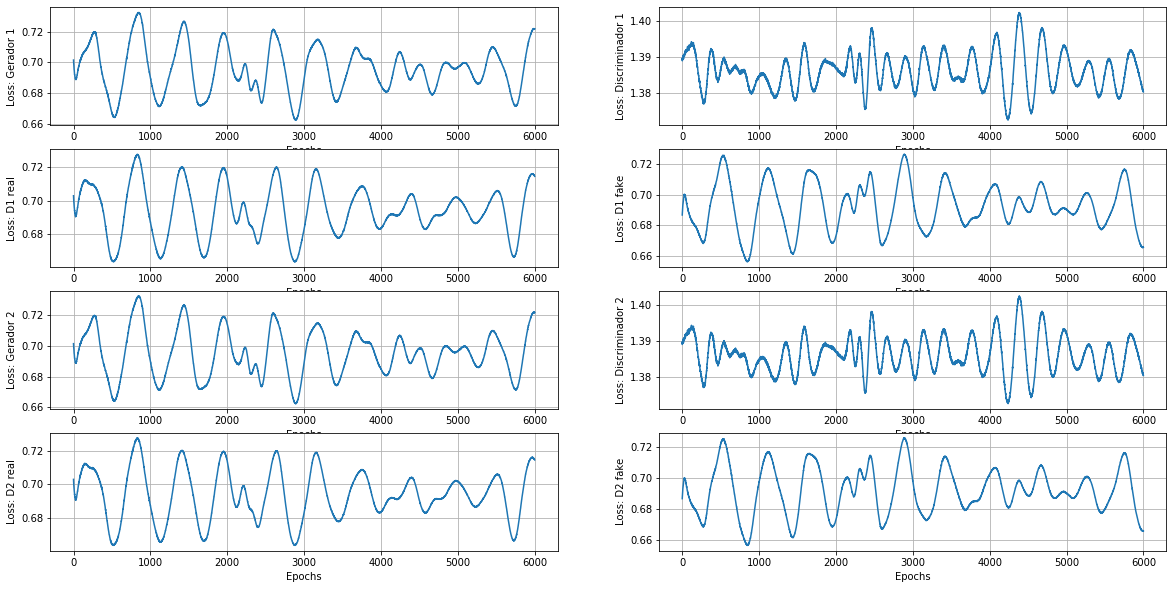

In [18]:
plot_losses(losses_his)

In [12]:
#save networks
# torch.save(G.state_dict(), 'models/g_cond_gan_shap_2.pt')
# torch.save(D.state_dict(), 'models/d_cond_gan_shap_2.pt')

## Reproduzindo mais dados como os do dataset inicial

Fake
      Image_quality  Number_of_images  Product_price  Seller_latitude  \
mean       4.229360          5.298960      19.436209        -0.236294   
std        1.006864          0.527474       5.172658         1.340816   
25%        4.000000          5.000000      15.200000        -1.367339   
50%        4.000000          5.000000      18.420000        -0.178337   
75%        5.000000          6.000000      22.870001         0.850715   

      Seller_longitude  Free_shipment  Click_probability  
mean         -0.278575       0.262100           0.423741  
std           3.100150       0.439781           0.072559  
25%          -2.534413       0.000000           0.370000  
50%          -1.102179       0.000000           0.420000  
75%           2.016366       1.000000           0.480000  
Real
      Image_quality  Number_of_images  Product_price  Seller_latitude  \
mean        4.48598          4.992660      21.093944         0.374182   
std         1.04611          1.035967       5.84087

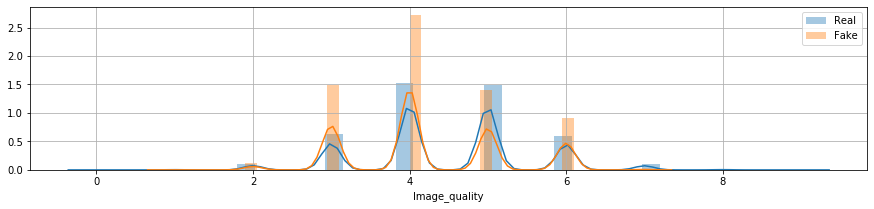

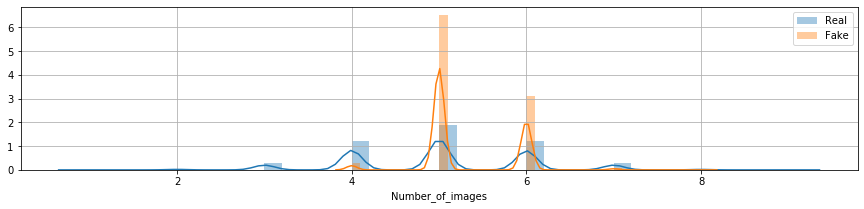

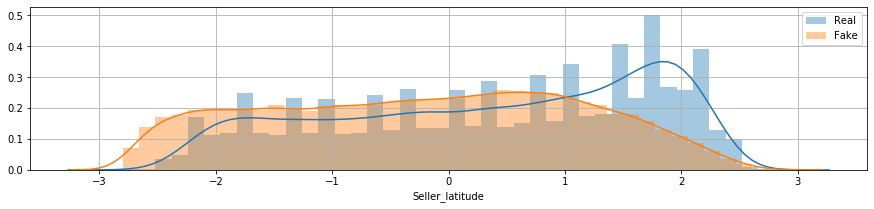

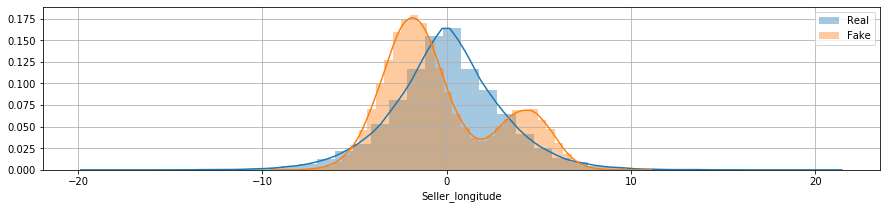

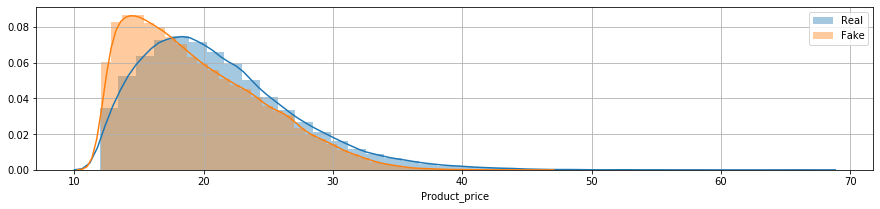

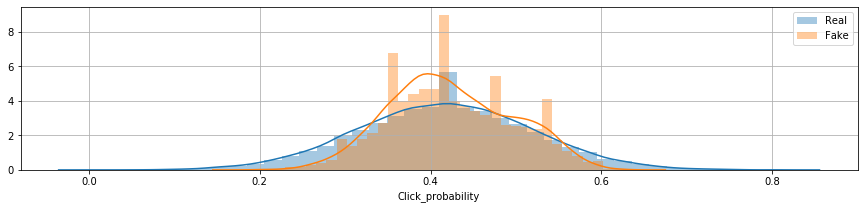

In [19]:
gan_summary()

## Intervenção

Fake
      Image_quality  Number_of_images  Product_price  Seller_latitude  \
mean       5.504560           5.55938      20.905930        -0.659521   
std        0.551639           0.54604       5.307035         1.292043   
25%        5.000000           5.00000      16.610001        -1.779625   
50%        6.000000           6.00000      20.320000        -0.750513   
75%        6.000000           6.00000      24.610001         0.354837   

      Seller_longitude  Free_shipment  Click_probability  
mean          4.153003            1.0           0.511663  
std           1.499268            0.0           0.040736  
25%           3.191122            1.0           0.490000  
50%           4.211884            1.0           0.510000  
75%           5.187706            1.0           0.540000  
Real
      Image_quality  Number_of_images  Product_price  Seller_latitude  \
mean        4.48598          4.992660      21.093944         0.374182   
std         1.04611          1.035967       5.84087

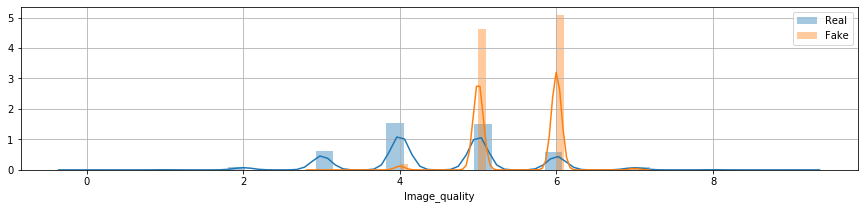

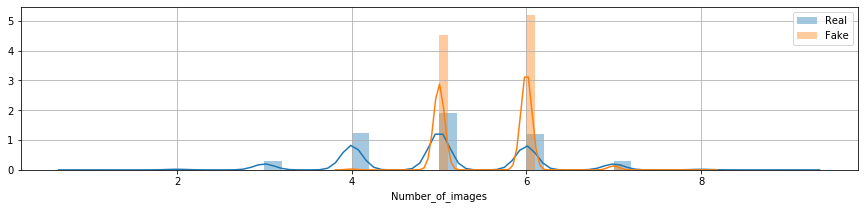

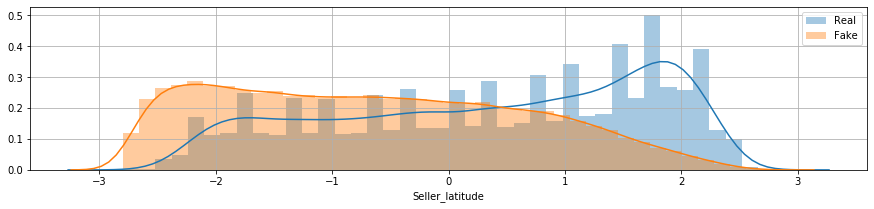

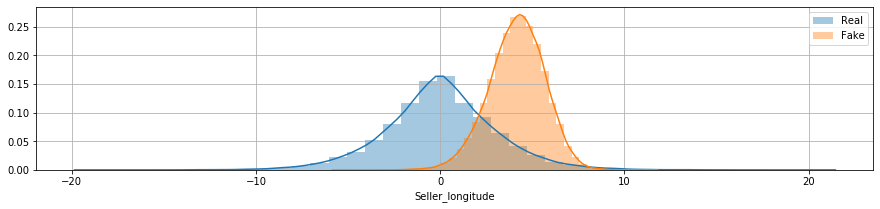

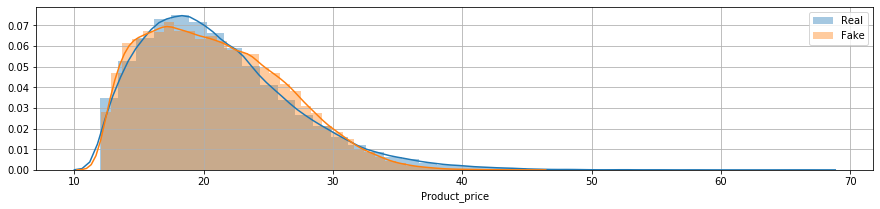

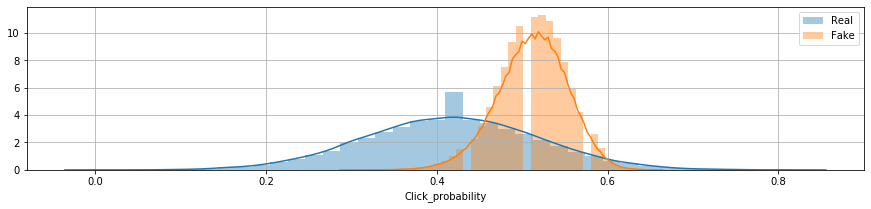

In [20]:
gan_summary(intervention=True)

Fake
      Image_quality  Number_of_images  Product_price  Seller_latitude  \
mean       5.505580          5.536320      21.000420        -0.649920   
std        0.552282          0.545424       5.346876         1.294840   
25%        5.000000          5.000000      16.660000        -1.765269   
50%        6.000000          6.000000      20.410000        -0.747079   
75%        6.000000          6.000000      24.730000         0.373598   

      Seller_longitude  Free_shipment  Click_probability  
mean          4.138267            1.0           0.510527  
std           1.482983            0.0           0.040584  
25%           3.191279            1.0           0.490000  
50%           4.202149            1.0           0.510000  
75%           5.140438            1.0           0.540000  
Real
      Image_quality  Number_of_images  Product_price  Seller_latitude  \
mean        4.48598          4.992660      21.093944         0.374182   
std         1.04611          1.035967       5.84087

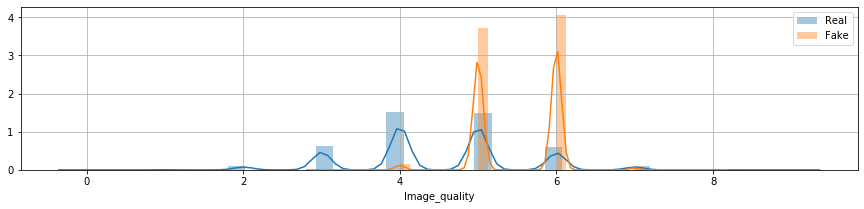

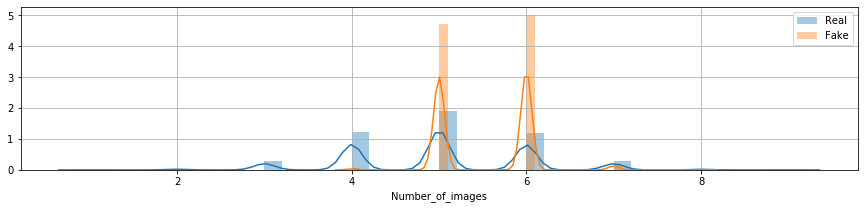

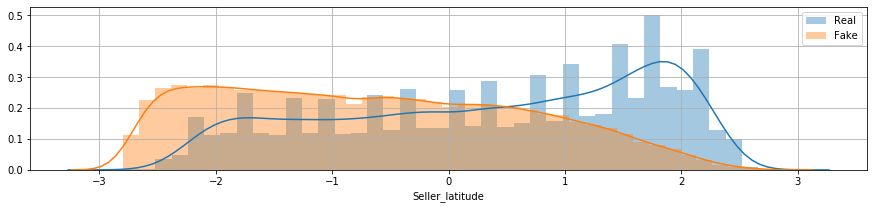

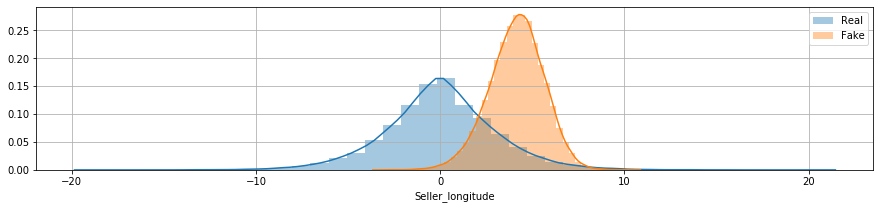

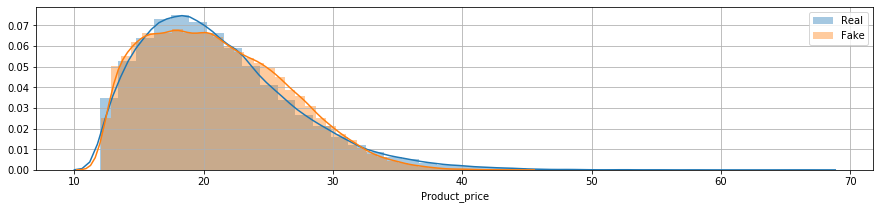

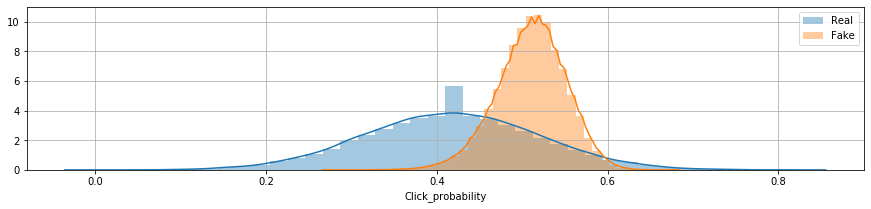

In [21]:
oh = np.eye(2)
batch = X_tc.shape[0]
l_s = np.random.choice([0,1],p=[0,1],size=(batch))
l_s_ = torch.Tensor(oh[l_s]).type(torch.FloatTensor).cuda()
l_s = torch.Tensor(l_s).type(torch.FloatTensor).reshape(batch,1).cuda()

z2 = Variable(torch.randn(batch, Z2_dim)).cuda()

g2 = G2(z2,X_tc[:,[0,1,3,4]].cuda(),l_s_)
g2 = torch.Tensor(scaler.inverse_transform(g2.cpu().data.numpy())).type(torch.FloatTensor).cuda()
x_gen = torch.cat((g2[:,0:5],l_s,g2[:,5:]),dim=1)

df_g = pd.DataFrame(data=x_gen.cpu().data.numpy(),columns=df_num.columns)

df_g['Click_probability'] = np.round(df_g['Click_probability'].values,2)
df_g['Image_quality'] = np.round(df_g['Image_quality'].values,0)
df_g['Number_of_images'] = np.round(df_g['Number_of_images'].values,0)
df_g['Product_price'] = np.round(df_g['Product_price'].values,2)

#dataset fake
print("Fake")
print(df_g.describe().loc[['mean','std','25%','50%','75%']])

#dataset real
print("Real")
print(df_num.describe().loc[['mean','std','25%','50%','75%']])

for col in ['Image_quality','Number_of_images','Seller_latitude','Seller_longitude','Product_price','Click_probability']:
    plt.figure(figsize=(15,3))
    sns.distplot(df_num[col],label='Real',bins=40)
    sns.distplot(df_g[col],label='Fake',bins=40)
    plt.legend(loc=0)
    plt.grid(True)
    plt.show()